In [1]:
import torch
from torch import nn
from torch.autograd import Variable
from torchvision import transforms
import torchvision.transforms as tfs
from torch.utils.data import DataLoader, sampler
from torchvision.datasets import MNIST
import torchvision
import torchvision.utils as vutils
import os
import numpy as np


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
# data_loader
img_size = 32
preprocess_img = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

DATA_DIR = 'data/' # data/faces/xxx.jpg (train dataset)
OUT_DIR = 'CGAN_fake_images'# data/fake_images/xxx.jpg (store the generated pics)

In [3]:
class ChunkSampler(sampler.Sampler): # 定义一个取样的函数
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

NUM_TRAIN = 50000
NUM_VAL = 5000

NOISE_DIM = 100
BATCH_SIZE = 64

train_set = MNIST('./mnist', train=True, download=True, transform=preprocess_img)

train_data = DataLoader(train_set, batch_size=BATCH_SIZE, sampler=ChunkSampler(NUM_TRAIN, 0))

val_set = MNIST('./mnist', train=True, download=True, transform=preprocess_img)

val_data = DataLoader(val_set, batch_size=BATCH_SIZE, sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))

In [4]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        if m.weight.requires_grad:
            m.weight.data.normal_(std=0.02)
        if m.bias is not None and m.bias.requires_grad:
            m.bias.data.fill_(0)
    elif isinstance(m, nn.BatchNorm2d) and m.affine:
        if m.weight.requires_grad:
            m.weight.data.normal_(1, 0.02)
        if m.bias.requires_grad:
            m.bias.data.fill_(0)

In [5]:
class discriminator_dc(nn.Module):
    def __init__(self):
        super(discriminator_dc, self).__init__()
        self.conv1_1 = nn.Sequential(#input 1x32x32
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
        )# 64 x 16 x 16
        self.conv1_2 = nn.Sequential(#input 10x32x32
            nn.Conv2d(10, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
        )# 64 x 16 x 16
        self.conv2 = nn.Sequential(#input 128 x 16 x 16
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
        )# 256 x 8 x 8
        self.conv3 = nn.Sequential(#input 256 x 8 x 8
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
        )# 512 x 4 x 4
        self.conv5 = nn.Sequential(# 512 x 4 x 4
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )# 1 x 1 x 1
        self.apply(init_weights)
        
    def forward(self,x ,label):
        x = self.conv1_1(x)# 64 x 16 x 16
        label = self.conv1_2(label)# 64 x 16 x 16
        x_c = torch.cat((x, label), dim=1)# bs x 128 x 16 x 16
        x_c = self.conv2(x_c)# bs x 256 x 8 x 8
        x_c = self.conv3(x_c)# bs x 512 x 4 x 4
        x = self.conv5(x_c)# bs x 1 x 1 x 1
        return x.view(x.shape[0],-1)


class generator_dc(nn.Module): 
    def __init__(self):
        super(generator_dc, self).__init__()
        self.deconv1_1 = nn.Sequential(# bs x 100 x 1 x 1,
            nn.ConvTranspose2d(100, 256, 4, 1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
        )# 256 x  4 x 4
        self.deconv1_2 = nn.Sequential(# bs x 10 x 1 x 1,
            nn.ConvTranspose2d(10, 256, 4, 1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
        )# 256 x  4 x 4
        
        self.conv = nn.Sequential(
            #bs x 512 x 4 x 4
            nn.ConvTranspose2d(512, 256, 4, 2, padding=1),# 256 x  8 x 8
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, padding=1),# 128 x  16 x 16
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 1, 4, 2, padding=1),# 1 x  32 x 32
            nn.Tanh()
        )# bs x 1 x  32 x 32
        self.apply(init_weights)
        
    def forward(self, x , label):
        x = self.deconv1_1(x) # bs x 256 x 4 x 4
        label = self.deconv1_2(label) #bs x 256 x 4 x 4
        x_c = torch.cat((x, label), dim=1)# bs x 512 x 4 x 4
        x = self.conv(x_c) # [b,1,32,32]
        return x

In [6]:
for x,y in train_data:
    #Discriminator
    #real_data = x.view(batch_size, -1).cuda()
    real_data = x.cuda()

    G_label = y.view(-1,1)
    G_label = torch.zeros(BATCH_SIZE, 10).scatter_(1, G_label, 1)
    G_label = G_label.unsqueeze(-1).unsqueeze(-1)# bs,10,1,1
    D_label = G_label.repeat(1,1,img_size,img_size)# bs,10,32,32
    break
    

In [7]:
bce_loss = nn.BCELoss()

def discriminator_loss(real_preds,fake_preds):
    size = real_preds.shape[0]
    true_labels = torch.ones(size,1).float().cuda()
    false_labels = torch.zeros(size,1).float().cuda()
    loss = bce_loss(real_preds,true_labels) + bce_loss(fake_preds,false_labels)
    return loss

def generator_loss(fake_preds):
    size = fake_preds.shape[0]
    true_labels = torch.ones(size,1).float().cuda()
    loss = bce_loss(fake_preds,true_labels)
    return loss

def get_adam_optimizer(net):
    optimizer = torch.optim.Adam(net.parameters(), lr=3e-4, betas=(0.5, 0.999))
    return optimizer

In [8]:
def train(data_iter,D_net,G_net,D_opt,G_opt,d_loss_func,g_loss_func,noise_size = 100,EPOCH = 10,show_every = 50):
    iter_count = 0
    
    loss = {'d': [], 'g': []}
    
    for epoch in range(EPOCH):
        for x,y in data_iter:
            #Discriminator
            #real_data = x.view(batch_size, -1).cuda()
            real_data = x.cuda()
            
            G_label = y.view(-1,1)
            G_label = torch.zeros(x.shape[0], 10).scatter_(1, G_label, 1)
            G_label = G_label.unsqueeze(-1).unsqueeze(-1).cuda()# bs,10,1,1
            D_label = G_label.repeat(1,1,img_size,img_size).cuda()# bs,10,32,32
            
            sample_noise = (torch.rand(x.shape[0], noise_size).unsqueeze(-1).unsqueeze(-1) - 0.5) / 0.5 # -1 ~ 1
            fake_inputs = sample_noise.cuda() #bs,100,1,1
            
            real_preds = D_net(real_data,D_label)#bs,1,32,32
            
            fake_images = G_net(fake_inputs,G_label) 
            fake_preds = D_net(fake_images,D_label)
            
            d_loss = d_loss_func(real_preds,fake_preds)
            
            #optimize discriminator
            D_opt.zero_grad()
            d_loss.backward()
            D_opt.step()

            #generator
            fake_inputs = sample_noise.cuda()
            fake_images = G_net(fake_inputs,G_label) 
            fake_preds = D_net(fake_images,D_label)
            g_loss = g_loss_func(fake_preds)
            #optimize generator
            G_opt.zero_grad()
            g_loss.backward()
            G_opt.step()
            
            loss['d'].append(d_loss.cpu().data.numpy())
            loss['g'].append(g_loss.cpu().data.numpy())
            
            if (iter_count % show_every == 0):
                print('Epoch: {},Iter: {}, D: {:.4}, G:{:.4}'.format(epoch,iter_count, d_loss.cpu().data.numpy(), g_loss.cpu().data.numpy()))
            iter_count += 1
            
        #generate 100 images and each row indicates the same number from 0 to 9
        sample_noise = (torch.rand(100, noise_size).unsqueeze(-1).unsqueeze(-1) - 0.5) / 0.5 # -1 ~ 1
        fake_inputs = sample_noise.cuda() #100,100,1,1
        
        G_label = torch.tensor([[i]*10 for i in range(10)]).view(100,-1)#100,1
        G_label = torch.zeros(100, 10).scatter_(1, G_label, 1)
        G_label = G_label.unsqueeze(-1).unsqueeze(-1).cuda()# 100,10,1,1
        generated_image = G_net(fake_inputs,G_label)
    
    
        vutils.save_image(generated_image.data.cpu(),
                  '%s/fake_samples_epoch_%03d.png' % (os.path.join(DATA_DIR, OUT_DIR), epoch),
                  normalize=True,nrow = 10)
 
        #torch.save(G_net.state_dict(), '%s/netG_%03d.pth' % (DATA_DIR, epoch))
        #torch.save(D_net.state_dict(), '%s/netD_%03d.pth' % (DATA_DIR, epoch))

    # plot the loss function versus number of iterations
    plt.plot(loss['d'], label='Discriminator')
    plt.plot(loss['g'], label='Generator')
    plt.legend(loc='upper right')
    plt.savefig(os.path.join(DATA_DIR, OUT_DIR,'Loss.png'))
    plt.show()

Epoch: 0,Iter: 0, D: 2.04, G:5.961
Epoch: 0,Iter: 250, D: 0.7287, G:4.106
Epoch: 0,Iter: 500, D: 1.069, G:2.989
Epoch: 0,Iter: 750, D: 1.052, G:0.8409
Epoch: 1,Iter: 1000, D: 0.9109, G:2.964
Epoch: 1,Iter: 1250, D: 0.8713, G:1.633
Epoch: 1,Iter: 1500, D: 1.192, G:2.39
Epoch: 2,Iter: 1750, D: 1.235, G:1.244
Epoch: 2,Iter: 2000, D: 1.036, G:1.567
Epoch: 2,Iter: 2250, D: 0.7633, G:1.429
Epoch: 3,Iter: 2500, D: 0.7032, G:1.998
Epoch: 3,Iter: 2750, D: 0.8497, G:3.152
Epoch: 3,Iter: 3000, D: 1.058, G:2.519
Epoch: 4,Iter: 3250, D: 0.6875, G:2.437
Epoch: 4,Iter: 3500, D: 0.4725, G:3.298
Epoch: 4,Iter: 3750, D: 0.4295, G:2.429
Epoch: 5,Iter: 4000, D: 0.4899, G:4.062
Epoch: 5,Iter: 4250, D: 0.3246, G:1.696
Epoch: 5,Iter: 4500, D: 0.3516, G:5.319
Epoch: 6,Iter: 4750, D: 0.3061, G:5.269
Epoch: 6,Iter: 5000, D: 0.1636, G:4.858
Epoch: 6,Iter: 5250, D: 0.285, G:2.238
Epoch: 7,Iter: 5500, D: 1.772, G:6.185
Epoch: 7,Iter: 5750, D: 0.1618, G:4.678
Epoch: 7,Iter: 6000, D: 0.666, G:6.875
Epoch: 7,Iter: 62

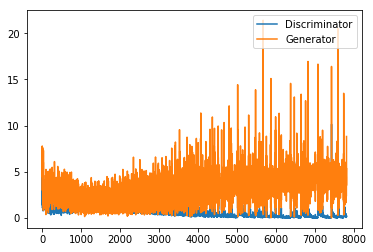

In [9]:
D = discriminator_dc().cuda()
G = generator_dc().cuda()

D_optim = get_adam_optimizer(D)
G_optim = get_adam_optimizer(G)

train(train_data,D, G, D_optim, G_optim, discriminator_loss, generator_loss,noise_size = NOISE_DIM,EPOCH = 10,show_every = 250)

In [10]:
#generate gif
from imageio import imread, imsave, mimsave
images = []
filenames=sorted((fn for fn in os.listdir(os.path.join(DATA_DIR, OUT_DIR)) if fn.endswith('.png')))
for filename in filenames:
    images.append(imread(os.path.join(DATA_DIR, OUT_DIR,filename)))
    
mimsave(os.path.join(DATA_DIR, OUT_DIR, 'samples.gif'), images, fps=10,duration=0.5)